# Installing and importing packages

In [ ]:
pip uninstall tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.15.0


In [ ]:
pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from transformers import BertTokenizer, BertModel
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import ast

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [ ]:
movies = pd.read_csv("/content/drive/My Drive/temp/movies_metadata.csv")

## Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [ ]:
# Helper function to clean and lemmatize text
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]
    return ' '.join(lemmatized_tokens)

# Convert relevant columns to lists and lemmatize them
def preprocess_column(column_data):
    column_data = column_data.apply(lambda x: ' '.join(ast.literal_eval(x)))
    return column_data.apply(lemmatize_text)

In [ ]:
# Preprocess genre, cast, writer, and production columns
movies['movie_genre_lemmatized'] = preprocess_column(movies['movie_genre'])
movies['movie_cast_lemmatized'] = preprocess_column(movies['movie_cast'])
movies['movie_director_lemmatized'] = preprocess_column(movies['movie_director'])
movies['movie_writer_lemmatized'] = preprocess_column(movies['movie_writer'])
movies['production_companies_lemmatized'] = preprocess_column(movies['production_companies'])
movies['movie_description_lemmatized'] = movies['movie_description'].apply(lemmatize_text)

##TF-IDF

In [ ]:
# Generating the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
description_matrix = tfidf_vectorizer.fit_transform(movies['movie_description_lemmatized'])

In [ ]:
# Getting the cosine similarity scores for tfidf
description_similarity = cosine_similarity(description_matrix, dense_output=False)

In [ ]:
# Defining a function to get the top few similar movies
def similar_movies(movie_name, similarity_matrix, movies_data, n_elements):
    """
    Generate top N similar movies for a given movie ID.

    Parameters:
    - movie_id (int): The index of the movie in the movies_data DataFrame.
    - similarity_matrix (ndarray): The similarity matrix for movies.
    - movies_data (pd.DataFrame): The DataFrame containing movie information.
    - n_elements (int): Number of top similar movies to return (default is 5).

    Returns:
    - List of tuples containing similar movie titles and similarity scores.
    """

    idx = movies[movies['movie_title'].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        return f"Movie titled '{movie_name}' not found in the dataset."

    movie_id = idx[0]

    similarity = {}

    # Ensure movie_id is within the bounds
    if movie_id < 0 or movie_id >= similarity_matrix.shape[0]:
        print("Invalid movie ID.")
        return []

    target_movie = movies_data.iloc[movie_id]
    print("Target Movie:")
    print(f"Title: {target_movie['movie_title']}")
    print(f"Description: {target_movie['movie_description']}")
    print(f"Genre: {target_movie['movie_genre']}")
    print("-----")

    # Compute similarities with all other movies
    for col in range(similarity_matrix.shape[1]):
        if col != movie_id:  # Exclude the movie itself
            similarity[col] = similarity_matrix[movie_id, col]

    # Sort by similarity score and retrieve the top N similar movies
    recommendations = sorted(similarity.items(), key=lambda x: x[1], reverse=True)[:n_elements]

    # Print and collect movie info
    top_similar_movies = []
    print("Recommended Movies:")
    for movie_id, sim_score in recommendations:
        movie_info = movies_data.iloc[movie_id]
        title = movie_info['movie_title']
        print(f"Title: {title}")
        print(f"Similarity Score: {sim_score}")
        print(f"Genre: {movies_data.iloc[movie_id]['movie_genre']}")
        print(f"Description: {movies_data.iloc[movie_id]['movie_description']}")
        print("-----")
        top_similar_movies.append((title, sim_score))

    return top_similar_movies


In [ ]:
# Getting the top 10 similar movies using tfidf
top_movies = similar_movies('the birth of a nation (1915)', description_similarity, movies, 10)

Target Movie:
Title: the birth of a nation (1915)
Description: Two families, abolitionist Northerners the Stonemans and Southern landowners the Camerons, intertwine. When Confederate colonel Ben Cameron is captured in battle, nurse Elsie Stoneman petitions for his pardon. In Reconstruction-era South Carolina, Cameron founds the Ku Klux Klan, battling Elsie's congressman father and his African-American protégé, Silas Lynch.
Genre: ['Biography', 'Drama', 'History', 'War']
-----
Recommended Movies:
Title: the chamber (1996)
Similarity Score: 0.1631771396479017
Genre: ['Crime', 'Drama']
Description: Idealistic young attorney Adam Hall takes on the death row clemency case of his racist grandfather, Sam Cayhall, a former Ku Klux Klan member he has never met.
-----
Title: the best of enemies (2019)
Similarity Score: 0.15137211254126304
Genre: ['Drama', 'History']
Description: Centers on the unlikely relationship between Ann Atwater, an outspoken civil rights activist, and C.P. Ellis, a local 

## BERT

In [ ]:
# Initializing the sentence transformer using bert
model = SentenceTransformer('bert-base-nli-mean-tokens')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Embedding the data
movies['bert_description_embedding'] = list(model.encode(movies['movie_description_lemmatized'], show_progress_bar=True))

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
# Getting the cosine similarity scores from BERT embeddings
description_embeddings = np.vstack(movies['bert_description_embedding'].values)
bert_similarity = cosine_similarity(description_embeddings, dense_output=False)

In [ ]:
# getting the top 10 movies using bert
topmovies = similar_movies('the birth of a nation (1915)', bert_similarity, movies, n_elements=10)

Target Movie:
Title: the birth of a nation (1915)
Description: Two families, abolitionist Northerners the Stonemans and Southern landowners the Camerons, intertwine. When Confederate colonel Ben Cameron is captured in battle, nurse Elsie Stoneman petitions for his pardon. In Reconstruction-era South Carolina, Cameron founds the Ku Klux Klan, battling Elsie's congressman father and his African-American protégé, Silas Lynch.
Genre: ['Biography', 'Drama', 'History', 'War']
-----
Recommended Movies:
Title: free state of jones (2016)
Similarity Score: 0.8477860689163208
Genre: ['Action', 'Biography', 'Drama', 'History', 'War']
Description: In 1863, Mississippi farmer Newt Knight serves as a medic for the Confederate Army. Opposed to slavery, Knight would rather help the wounded than fight the Union. After his nephew dies in battle, Newt returns home to Jones County to safeguard his family but is soon branded an outlaw deserter. Forced to flee, he finds refuge with a group of runaway slaves 

In [ ]:
# transforming the similarity scores to the same shape to plot the comparison graph
tfidf_similarity_scores = description_similarity[np.triu_indices_from(description_similarity, k=1)]
tfidf_similarity_scores = np.array(tfidf_similarity_scores).flatten()
bert_similarity_scores = bert_similarity[np.triu_indices_from(bert_similarity, k=1)]

In [ ]:
tfidf_similarity_scores.shape, bert_similarity_scores.shape

((154431525,), (154431525,))

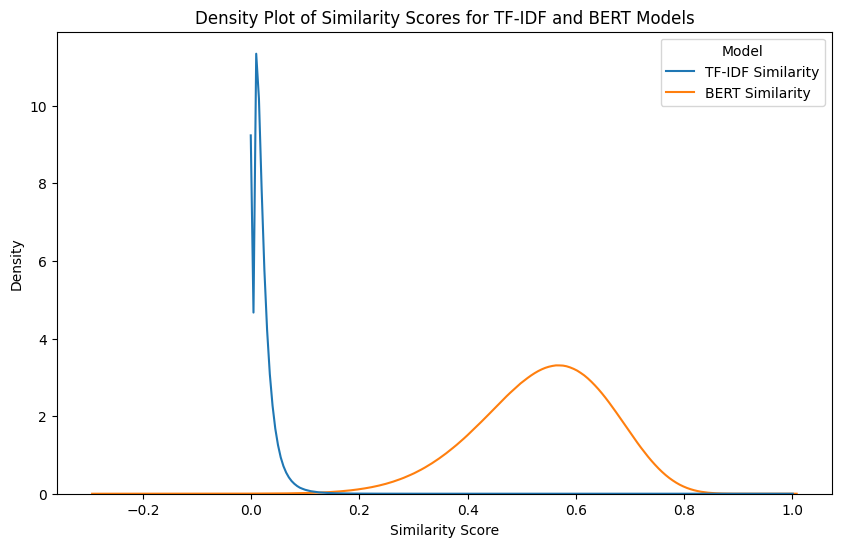

In [ ]:
similarity_data = pd.DataFrame({
    'TF-IDF Similarity': tfidf_similarity_scores,
    'BERT Similarity': bert_similarity_scores
})
similarity_data_melted = similarity_data.melt(var_name="Model", value_name="Similarity Score")

# Plot density
plt.figure(figsize=(10, 6))
sns.kdeplot(data=similarity_data_melted, x="Similarity Score", hue="Model", common_norm=False)
plt.title('Density Plot of Similarity Scores for TF-IDF and BERT Models')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.show()

The TF-IDF model has a sharp peak near 0, indicating that the majority of similarity scores are close to 0. This suggests that TF-IDF does not capture much similarity between pairs, likely because it only considers raw frequency and lacks deep context.
The BERT model shows a smoother peak around 0.4-0.6, indicating that it detects higher similarity scores more frequently. This pattern reflects BERT’s ability to capture more meaningful semantic similarities between texts compared to TF-IDF. Since using BERT is more effective in capturing nuanced, contextual similarities for the movie descriptions, we will use the BERT model for all feature embeddings.

## Fitting the model using more features

In [ ]:
# embedding all the other features
movies['bert_genre_embedding'] = list(model.encode(movies['movie_genre_lemmatized'], show_progress_bar=True))
movies['bert_cast_embedding'] = list(model.encode(movies['movie_cast_lemmatized'], show_progress_bar=True))
movies['bert_director_embedding'] = list(model.encode(movies['movie_director_lemmatized'], show_progress_bar=True))
movies['bert_writer_embedding'] = list(model.encode(movies['movie_writer_lemmatized'], show_progress_bar=True))
movies['bert_production_embedding'] = list(model.encode(movies['production_companies_lemmatized'], show_progress_bar=True))

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

Batches:   0%|          | 0/550 [00:00<?, ?it/s]

In [ ]:
# converting embeddings to array
description_emb = np.array(movies['bert_description_embedding'].tolist())
genre_emb = np.array(movies['bert_genre_embedding'].tolist())
cast_emb = np.array(movies['bert_cast_embedding'].tolist())
director_emb = np.array(movies['bert_director_embedding'].tolist())
writer_emb = np.array(movies['bert_writer_embedding'].tolist())
production_emb = np.array(movies['bert_production_embedding'].tolist())

# Concatenate the embeddings
combined_embeddings = np.hstack([
    description_emb * 0.3,
    genre_emb * 0.3,
    cast_emb * 0.1,
    director_emb * 0.1,
    writer_emb * 0.1,
    production_emb * 0.1
])

# Normalize the combined embeddings (useful for cosine similarity)
combined_embeddings = normalize(combined_embeddings)
combined_similarity = cosine_similarity(combined_embeddings, dense_output=False)

In [ ]:
# getting the top 10 movies using all features under bert
topmovies = similar_movies('the birth of a nation (1915)', combined_similarity, movies, n_elements=10)

Target Movie:
Title: the birth of a nation (1915)
Description: Two families, abolitionist Northerners the Stonemans and Southern landowners the Camerons, intertwine. When Confederate colonel Ben Cameron is captured in battle, nurse Elsie Stoneman petitions for his pardon. In Reconstruction-era South Carolina, Cameron founds the Ku Klux Klan, battling Elsie's congressman father and his African-American protégé, Silas Lynch.
Genre: ['Biography', 'Drama', 'History', 'War']
-----
Recommended Movies:
Title: glory (1989)
Similarity Score: 0.8656956553459167
Genre: ['Biography', 'Drama', 'History', 'War']
Description: Robert Gould Shaw leads the US Civil War's first all-black volunteer company, fighting prejudices of both his own Union army and the Confederates.
-----
Title: gods and generals (2003)
Similarity Score: 0.8598830103874207
Genre: ['Biography', 'Drama', 'History', 'War']
Description: The film centers mostly around the personal and professional life of Thomas "Stonewall" Jackson, a

## KNN

In [ ]:
# knn model for bert embeddings
knn_bert = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
knn_bert.fit(description_embeddings)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [ ]:
# function to get recommendations from bert embeddings
def get_recommendations_bert(movie_name, embeddings, knn_model):

    idx = movies[movies['movie_title'].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        return f"Movie titled '{movie_name}' not found in the dataset."

    idx = idx[0]
    distances, indices = knn_model.kneighbors([embeddings[idx]])

    filtered_indices = indices[0][1:]  # Exclude the first index, which is the input movie
    filtered_distances = distances[0][1:]

    target_movie = movies.iloc[idx]
    print("Target Movie:")
    print(f"Title: {target_movie['movie_title']}")
    print(f"Description: {target_movie['movie_description']}")
    print(f"Genre: {target_movie['movie_genre']}")
    print("-----")


    # Collect recommendation details
    recommendations = []
    for i, idx in enumerate(filtered_indices):
        row = movies.iloc[idx]
        similarity_score = 1 - filtered_distances[i]  # Convert cosine distance to similarity
        recommendations.append({
            'title': row['movie_title'],
            'similarity': similarity_score,
            'genre': row['movie_genre'],
            'description': row['movie_description']
        })

    print("Recommended Movies:")
    for i in recommendations:
        print(f"Title: {i['title']}")
        print(f"Similarity Score: {i['similarity']}")
        print(f"Genre: {i['genre']}")
        print(f"Description: {i['description']}")
        print("-----")

In [ ]:
get_recommendations_bert('jonah hex (2010)', description_embeddings, knn_bert)

Target Movie:
Title: jonah hex (2010)
Description: Gunslinger Jonah Hex (Josh Brolin) is appointed by President Ulysses Grant to track down terrorist Quentin Turnbull (John Malkovich), a former Confederate officer determined on unleashing hell on earth. Jonah not only secures freedom by accepting this task, he also gets revenge on the man who slayed his wife and child. Megan Fox plays a prostitute as well as Jonah Hex's love interst in the film.
Genre: ['Action', 'Adventure', 'Drama', 'Fantasy', 'Mystery', 'Thriller', 'Western']
-----
Recommended Movies:
Title: dahmer vs. gacy (2010)
Similarity Score: 0.8816593885421753
Genre: ['Comedy', 'Horror']
Description: A secret government lab run by Dr. Hess (Art LaFleur) has been trying to create the ultimate killer using the DNA of infamous killers Jeffrey Dahmer (Ford Austin) and John Wayne Gacy (Randal Malone), but there’s one big problem: they’ve escaped! Bloody mayhem stretches across the United States as they go on the ultimate killing s

In [ ]:
# knn model for tfidf scores
knn_tfidf = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
knn_tfidf.fit(description_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [ ]:
# function for getting the top few recommended movies using tfidf scores
def get_recommendations_tfidf(movie_name, embeddings, knn_model):

    idx = movies[movies['movie_title'].str.lower() == movie_name.lower()].index
    if len(idx) == 0:
        return f"Movie titled '{movie_name}' not found in the dataset."

    idx = idx[0]
    distances, indices = knn_tfidf.kneighbors(embeddings[idx])

    filtered_indices = indices[0][1:]  # Exclude the first index, which is the input movie
    filtered_distances = distances[0][1:]

    target_movie = movies.iloc[idx]
    print("Target Movie:")
    print(f"Title: {target_movie['movie_title']}")
    print(f"Description: {target_movie['movie_description']}")
    print(f"Genre: {target_movie['movie_genre']}")
    print("-----")


    # Collect recommendation details
    recommendations = []
    for i, idx in enumerate(filtered_indices):
        row = movies.iloc[idx]
        similarity_score = 1 - filtered_distances[i]  # Convert cosine distance to similarity
        recommendations.append({
            'title': row['movie_title'],
            'similarity': similarity_score,
            'genre': row['movie_genre'],
            'description': row['movie_description']
        })

    print("Recommended Movies:")
    for i in recommendations:
        print(f"Title: {i['title']}")
        print(f"Similarity Score: {i['similarity']}")
        print(f"Genre: {i['genre']}")
        print(f"Description: {i['description']}")
        print("-----")

In [ ]:
get_recommendations_tfidf('jonah hex (2010)', description_matrix, knn_tfidf)

Target Movie:
Title: jonah hex (2010)
Description: Gunslinger Jonah Hex (Josh Brolin) is appointed by President Ulysses Grant to track down terrorist Quentin Turnbull (John Malkovich), a former Confederate officer determined on unleashing hell on earth. Jonah not only secures freedom by accepting this task, he also gets revenge on the man who slayed his wife and child. Megan Fox plays a prostitute as well as Jonah Hex's love interst in the film.
Genre: ['Action', 'Adventure', 'Drama', 'Fantasy', 'Mystery', 'Thriller', 'Western']
-----
Recommended Movies:
Title: the haunting in connecticut (2009)
Similarity Score: 0.12473047910312884
Genre: ['Drama', 'Horror', 'Mystery', 'Thriller']
Description: When the Campbell family moves to upstate Connecticut, they soon learn that their charming Victorian home has a disturbing history: not only was the house a transformed funeral parlor where inconceivable acts occurred, but the owner's clairvoyant son Jonah served as a demonic messenger, providin

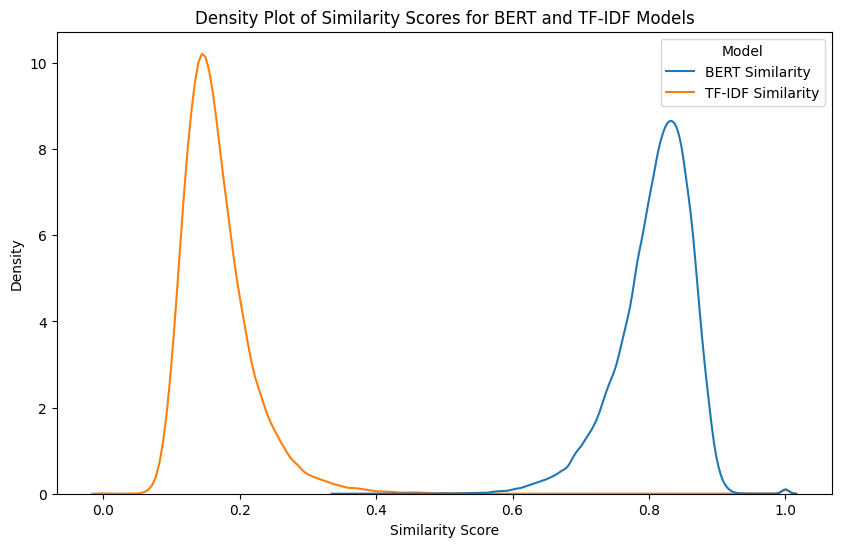

In [ ]:
# Calculating similarity scores for BERT-based KNN model
distances_bert, _ = knn_bert.kneighbors(description_embeddings, n_neighbors=10)
similarity_scores_bert = 1 - distances_bert[:, 1:].flatten()  # Flatten and exclude self-similarity

# Calculating similarity scores for TF-IDF-based KNN model
distances_tfidf, _ = knn_tfidf.kneighbors(description_matrix, n_neighbors=10)
similarity_scores_tfidf = 1 - distances_tfidf[:, 1:].flatten()  # Flatten and exclude self-similarity

# Prepare data for plotting
similarity_data = pd.DataFrame({
    'BERT Similarity': similarity_scores_bert,
    'TF-IDF Similarity': similarity_scores_tfidf
})
similarity_data_melted = similarity_data.melt(var_name="Model", value_name="Similarity Score")

# Plot density comparison
plt.figure(figsize=(10, 6))
sns.kdeplot(data=similarity_data_melted, x="Similarity Score", hue="Model", common_norm=False)
plt.title('Density Plot of Similarity Scores for BERT and TF-IDF Models')
plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.show()

The BERT model (blue line) has a peak around the higher similarity score range (0.8 to 1.0), while TF-IDF model (orange line) has a peak around a lower similarity score (close to 0.0). Using the KNN method amplifies the effect of each model's underlying characteristics, where BERT identifies closer and more contextually similar neighbors, and TF-IDF has a sparse similarity distribution with fewer close neighbors.


In [ ]:
# knn model for all the combined features
knn_combined = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='brute')
knn_combined.fit(combined_embeddings)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

In [ ]:
get_recommendations_bert('jonah hex (2010)', combined_embeddings, knn_combined)

Target Movie:
Title: jonah hex (2010)
Description: Gunslinger Jonah Hex (Josh Brolin) is appointed by President Ulysses Grant to track down terrorist Quentin Turnbull (John Malkovich), a former Confederate officer determined on unleashing hell on earth. Jonah not only secures freedom by accepting this task, he also gets revenge on the man who slayed his wife and child. Megan Fox plays a prostitute as well as Jonah Hex's love interst in the film.
Genre: ['Action', 'Adventure', 'Drama', 'Fantasy', 'Mystery', 'Thriller', 'Western']
-----
Recommended Movies:
Title: the proposition (2005)
Similarity Score: 0.8519158363342285
Genre: ['Action', 'Adventure', 'Crime', 'Drama', 'Thriller', 'Western']
Description: Set in the Australian outback in the 1880s, the movie follows the series of events following the horrific rape and murder of the Hopkins family, allegedly committed by the infamous Burns brothers gang. Captain Morris Stanley captures Charlie Burns and gives him 9 days to kill his older 